# Imputing Knowledge about Gene and Protein Function with Machine Learning

In [1]:
%matplotlib inline
# Imports
## Data processing
import pandas as pd
import numpy as np
import scipy as sp
## Machine Learning
import sklearn as sk
from sklearn import (
    preprocessing,
    decomposition,
    ensemble,
    model_selection,
    pipeline,
    metrics,
    manifold,
    feature_selection,
    linear_model,
    tree,
    svm,
    calibration,
)
## Plotting
from matplotlib import pyplot as plt
## Harmonizome API
from harmonizome import Harmonizome
## Utility
import re
import json
from functools import reduce
from IPython.display import display

In [2]:
# Utility functions

## Early stopping function
def early_stopping(n_rounds, tol=0.001):
    def early_stopping_func(i, self, local):
        rounds = getattr(self, '__rounds', 0)
        last = getattr(self, '__last', None)
        current = self.train_score_[i]
        if last and current and abs(current - last) < tol:
            rounds += 1
            if rounds > n_rounds:
                return True
        else:
            rounds = 0
        setattr(self, '__last', current)
        setattr(self, '__rounds', rounds)
        return False
    return early_stopping_func

## Create custom "randfloat" that behaves like randint but for floats
from scipy.stats import uniform, randint
def randfloat(start, end):
    ''' Utility function for generating a float uniform distribution '''
    return uniform(start, end - start)

# reproducable random seed
rng = 2018

## Inputs

Given a target attribute of interest, we will use machine learning to predict genes that are strongly correlated with that target. Using the Harmonizome data query API, we download the dataset containing the target attribute as well as a number of well-populated Omics datasets for more genes and features and build a large sparse dataframe.

In [3]:

attribute_datasets = ['CCLE Cell Line Gene Expression Profiles', 'ENCODE Transcription Factor Targets']
target_class = "lung oat cell carcinoma (DOID:5411 from DISEASES Text-mining Gene-Disease Assocation Evidence Scores)"

Select Omics datasets are downloaded and joined on the Gene producing a large association matrix. Only association is preserved in order to create a binary classification task.

In [4]:
# Download attribute datasets from Harmonizome
df_attributes = list(Harmonizome.download_df(
    [dataset
     for dataset in attribute_datasets],
    ['gene_attribute_matrix.txt.gz'],
))
for name, df in zip(attribute_datasets, df_attributes):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]

X = df.applymap(lambda f: 1 if f!=1 else 0)
print('Total Shape:', X.shape)
display(X.head())

CCLE Cell Line Gene Expression Profiles shape: (18025, 1037)


,"[""CHL1"", ""skin"", ""na""]","[""HMCB"", ""skin"", ""na""]","[""HS852T"", ""skin"", ""na""]","[""HS695T"", ""skin"", ""na""]","[""A101D"", ""skin"", ""na""]","[""HS294T"", ""skin"", ""na""]","[""SNU466"", ""central nervous system"", ""na""]","[""SKMEL31"", ""skin"", ""na""]","[""SKMEL24"", ""skin"", ""na""]","[""WM115"", ""skin"", ""na""]",...,"[""HEL9217"", ""haematopoietic and lymphoid tissue"", ""na""]","[""HEL"", ""haematopoietic and lymphoid tissue"", ""na""]","[""UT7"", ""haematopoietic and lymphoid tissue"", ""na""]","[""SET2"", ""haematopoietic and lymphoid tissue"", ""na""]","[""MOLM16"", ""haematopoietic and lymphoid tissue"", ""na""]","[""KU812"", ""haematopoietic and lymphoid tissue"", ""na""]","[""TF1"", ""haematopoietic and lymphoid tissue"", ""na""]","[""MEG01"", ""haematopoietic and lymphoid tissue"", ""na""]","[""KYO1"", ""haematopoietic and lymphoid tissue"", ""na""]","[""K562"", ""haematopoietic and lymphoid tissue"", ""na""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
ITGBL1,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
LRP1,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
LTBP2,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
PARVA,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


ENCODE Transcription Factor Targets shape: (22819, 181)


,"[""ARID3A"", ""na"", ""1820""]","[""ATF1"", ""na"", ""466""]","[""ATF2"", ""na"", ""1386""]","[""ATF3"", ""na"", ""467""]","[""BACH1"", ""na"", ""571""]","[""BATF"", ""na"", ""10538""]","[""BCL11A"", ""na"", ""53335""]","[""BCL3"", ""na"", ""602""]","[""BCLAF1"", ""na"", ""9774""]","[""BDP1"", ""na"", ""55814""]",...,"[""ZC3H11A"", ""na"", ""9877""]","[""ZEB1"", ""na"", ""6935""]","[""ZKSCAN1"", ""na"", ""7586""]","[""ZMIZ1"", ""na"", ""57178""]","[""ZNF143"", ""na"", ""7702""]","[""ZNF217"", ""na"", ""7764""]","[""ZNF263"", ""na"", ""10127""]","[""ZNF274"", ""na"", ""10782""]","[""ZNF384"", ""na"", ""171017""]","[""ZZZ3"", ""na"", ""26009""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Total Shape: (23364, 1218)


,"[""CHL1"", ""skin"", ""na""]","[""HMCB"", ""skin"", ""na""]","[""HS852T"", ""skin"", ""na""]","[""HS695T"", ""skin"", ""na""]","[""A101D"", ""skin"", ""na""]","[""HS294T"", ""skin"", ""na""]","[""SNU466"", ""central nervous system"", ""na""]","[""SKMEL31"", ""skin"", ""na""]","[""SKMEL24"", ""skin"", ""na""]","[""WM115"", ""skin"", ""na""]",...,"[""ZC3H11A"", ""na"", ""9877""]","[""ZEB1"", ""na"", ""6935""]","[""ZKSCAN1"", ""na"", ""7586""]","[""ZMIZ1"", ""na"", ""57178""]","[""ZNF143"", ""na"", ""7702""]","[""ZNF217"", ""na"", ""7764""]","[""ZNF263"", ""na"", ""10127""]","[""ZNF274"", ""na"", ""10782""]","[""ZNF384"", ""na"", ""171017""]","[""ZZZ3"", ""na"", ""26009""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,1,1,1,1,1,0,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
A1BG-AS1,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A1CF,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A2M,1,1,0,1,1,1,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1
A2ML1,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,1,1,0,1


We download the dataset containtaining the target class name and assemble an list of genes associated with that class.

In [5]:
# Separate target attribute and dataset
class_name, class_type, class_dataset = re.match(
    r'^(.+) \((.+) from (.+)\)$',
    target_class,
).groups()
target_class_col = class_name

# Download class datasets from Harmonizome
df_class = list(Harmonizome.download_df(
    [class_dataset],
    ['gene_attribute_matrix.txt.gz'],
))[0]
df_class.columns = df_class.columns.map(lambda s: json.loads(s)[0])
df_class.index.name = json.loads(df_class.index.name)[0]
df_class.index = df_class.index.map(lambda s: json.loads(s)[0])
print('%s shape:' % (class_dataset), df_class.shape)
display(df_class.head())

# Collect genes of interest
target_genes = df_class[df_class[target_class_col] == 1].index
print('Number of Target Genes:', len(target_genes))

DISEASES Text-mining Gene-Disease Assocation Evidence Scores shape: (15309, 4628)


,integumentary system cancer,skin cancer,skin carcinoma,basal cell carcinoma,keratoacanthoma,skin squamous cell carcinoma,actinic keratosis,seborrheic keratosis,verrucous carcinoma,infiltrative basal cell carcinoma,...,alternating exotropia,masters-allen syndrome,charcot-marie-tooth disease type 4,anal margin carcinoma,poland syndrome,cortical deafness,form agnosia,breast lipoma,queensland tick typhus,fatal infantile encephalocardiomyopathy
GeneSym,,,,,,,,,,,,,,,,,,,,,
LRRTM4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LRFN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMPA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM174B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of Target Genes: 45


We produce a target array containing 1 if the gene is associated and 0 otherwise.

In [6]:
# Create final target array
y = np.in1d(X.index, target_genes).astype(np.int8)
print('Known Target Genes: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))

# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Known Target Genes: 45 (0.193 %)
Input shape: (23364, 1218)
Target shape: (23364,)


## Dimensionality Reduction

We reduce the dimensionality of our omics feature space with .

In [7]:

clf_dimensionality_reduction = sk.decomposition.PCA(n_components=64)

In [8]:
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
if hasattr(clf_dimensionality_reduction, 'explained_variance_'):
    print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))

Explained variance: 27.397520430784734


## Machine Learning


In [9]:
feature_selection = sk.feature_selection.SelectFromModel(sk.svm.LinearSVC(loss="squared_hinge", penalty="l1", dual=False))
cv_algorithm = sk.model_selection.StratifiedKFold
algorithm = sk.ensemble.RandomForestClassifier()
hyper_param_search = sk.model_selection.RandomizedSearchCV
cross_validation_n_folds = 3
primary_metric = "roc_auc"
evaluation_metrics = []

In [10]:
cv = cv_algorithm(
    n_splits=cross_validation_n_folds,
    shuffle=True,
    random_state=rng,
)

model = sk.calibration.CalibratedClassifierCV(
    sk.pipeline.Pipeline([
        ('reduce_dim', clf_dimensionality_reduction),
        ('feature_selection', feature_selection),
        ('clf', algorithm),
    ]),
    cv=cv,
)

# Scoring parameters
scoring_params = {k: v
                  for k,v in metrics.scorer.SCORERS.items()
                  if k == primary_metric or k in evaluation_metrics}

This visualization shows illustrates the cross-validated performance of the model. Low fold variance and high AUC is desired in a well-generalized model.

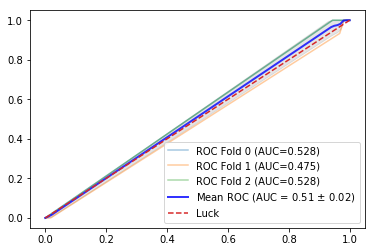

In [11]:
fig, ax = plt.subplots()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    fpr, tpr, _ = sk.metrics.roc_curve(y[test], y_proba[:, 1])
    tprs.append(sp.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sk.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4, label='ROC Fold %d (AUC=%0.3f)' % (fold, roc_auc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.plot([0,1],[0,1],'--', label='Luck')
ax.legend()

In [12]:
z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')

Confidence interval (95%) (0.46195227070897377, 0.5591401260384726)
We are 66.471 % confident the model's results are not just chance.
This is not statistically significant. These results should not be trusted.


This will take a long time as we are evaluating n_iter different models n_splits different times each computing all the metrics on `product(X.shape)` data points--not to mention the size of each model dictated by the range of parameters specified in the params dict.

In [13]:
cm = metrics.confusion_matrix(y, model.predict(X.values))
display(cm)
print('\n',
    'True labels predicted to be true:', cm[0,0], '\n',
    'True labels predicted to be false:', cm[0,1], '\n',
    'False labels predicted to be true:', cm[1,0], '\n',
    'False labels predicted to be false:', cm[1,1])

array([[23319,     0],
       [   45,     0]])


 True labels predicted to be true: 23319 
 True labels predicted to be false: 0 
 False labels predicted to be true: 45 
 False labels predicted to be false: 0


In [14]:
# Obtain prediction results
y_preds = model.predict(X)
y_probas = model.predict_proba(X)[:, 1]
results = pd.DataFrame(np.array([
    y,
    y_preds,
    y_probas,
]).T, columns=[
    'Known',
    'Predicted',
    'Prediction Probability',
], index=X.index)
results[(results['Prediction Probability'] > 0.5)]

,Known,Predicted,Prediction Probability
GeneSym,,,
